In [1]:
from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, load_mpl_presets
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from scipy.stats import bootstrap, skewnorm, linregress
from scipy.optimize import curve_fit
import numpy as np
import warnings
import random
import vice
import sys
load_mpl_presets()
warnings.filterwarnings("ignore")
print(sys.version_info)

sys.version_info(major=3, minor=10, micro=2, releaselevel='final', serial=0)


/Users/astrobeard/Work/Research/VICErepos/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [2]:
outputs = [
    "../outputs/inside-out/vrad0",
    "../outputs/inside-out/vrad1",
    "../outputs/inside-out/vrad2",
    "../outputs/inside-out/vrad3"
]
radial_velocities = [0, -1, -2, -3]
outputs = [vice.multioutput(_) for _ in outputs]
for out in outputs:
    extra = np.genfromtxt("%s_analogdata.out" % (out.name))
    zfinal = [row[-1] for row in extra]
    out.stars["absz"] = [abs(z) for z in zfinal][:out.stars.size[0]]

In [3]:
def skewnormal(x, a, mean, std):
    return 1 / std * skewnorm.pdf((x - mean) / std, a)

def skewnormal_estimate_mode(a, mean, std):
    r"""See notes in apogee.ipynb"""
    delta = a / np.sqrt(1 + a**2)
    term1 = (4 - np.pi) / 2 * delta**3 / (np.pi - 2 * delta**2)
    sgn = int(a > 0) - int(a < 0)
    factor = np.sqrt(2 / np.pi) * (delta - term1) - sgn / 2 * np.exp(-2 * np.pi / abs(a))
    return mean + std * factor

def skewnormal_mode_sample(sample, bins = np.linspace(-3, 2, 1001), axis = 1):
    centers = [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])]
    dist, _ = np.histogram(sample, bins = bins, density = True)
    opt, cov = curve_fit(skewnormal, centers, dist, p0 = [1, 0, 1])
    return np.array([skewnormal_estimate_mode(opt[0], opt[1], opt[2])])

def skewnormal_mode_sample_bootstrap(sample, bins = np.linspace(-3, 3, 1001)):
    centers = [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])]
    mode = skewnormal_mode_sample(sample, bins = bins)
    bootstrap_ci = bootstrap((sample,), skewnormal_mode_sample, confidence_level = 0.68,
        method = "percentile", random_state = 1)
    minus_err = mode - bootstrap_ci.confidence_interval.low
    plus_err = bootstrap_ci.confidence_interval.high - mode
    return np.array([mode, minus_err, plus_err])

def weighted_percentile(values, weights, percentile = 0.5):
	r"""
	Compute the n'th percentile of a weighted distribution. Despite the name,
	this function can compute any percentile, but by default it will be the
	50th (i.e. the median).

	Parameters
	----------
	values : ``list``
		The values for which the n'th percentile given some weightes is to be
		calculated.
	weights : ``list``
		The weights themselves. Must be the same length as ``values``.
	percentile : ``float`` [default : 0.5]
		In decimal representation, the percentile at which to stop the
		calculation. Default corresponds to 50th percentile.

	Returns
	-------
	median : ``float``
		The ``stop``'th percentile of the distribution of ``values``, weighted
		by ``weights``.
	"""
	indeces = np.argsort(values)
	values = [values[i] for i in indeces]
	weights = [weights[i] for i in indeces]
	weights = [i / sum(weights) for i in weights]
	s = 0
	for i in range(len(weights)):
		s += weights[i]
		if s > percentile:
			idx = i - 1
			break
	return values[idx]

In [5]:
zone_width = 0.1
radial_bins = list(range(0, 16, 1))

for i, out in enumerate(outputs):
    with open("./multizone/%s_stellar_gradient.out" % (out.name.split('/')[-1]), "w") as f:
        for j in range(len(radial_bins) - 1):
            f.write("%.3e\t" % ((radial_bins[j] + radial_bins[j + 1]) / 2))
            inner_zone = int(radial_bins[j] / zone_width)
            outer_zone = int(radial_bins[j + 1] / zone_width) - 1
            stars = out.stars.filter(
                "zone_final", ">=", inner_zone).filter(
                "zone_final", "<=", outer_zone).filter(
                "absz", "<=", 0.5).filter(
                "mass", ">=", 1)
            sys.stdout.write("\rR = %d - %d kpc ; N stellar pops: %d                    " % (
                radial_bins[j], radial_bins[j + 1], len(stars["mass"])))
            bins = [-3 + 0.01 * _ for _ in range(601)]
            
            mdf, _ = np.histogram(stars["[o/h]"], bins = bins, density = True, weights = stars["mass"])
            opt, cov = curve_fit(skewnormal, [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])], mdf,
                p0 = [1, 0, 1])
            oh_mode = skewnormal_estimate_mode(opt[0], opt[1], opt[2])
            oh_16th = weighted_percentile(stars["[o/h]"], stars["mass"], percentile = 0.16)
            oh_84th = weighted_percentile(stars["[o/h]"], stars["mass"], percentile = 0.84)
            f.write("%.3e\t%.3e\t%.3e\t" % (oh_16th, oh_mode, oh_84th))
            
            mdf, _ = np.histogram(stars["[fe/h]"], bins = bins, density = True, weights = stars["mass"])
            opt, cov = curve_fit(skewnormal, [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])], mdf,
                p0 = [1, 0, 1])
            feh_mode = skewnormal_estimate_mode(opt[0], opt[1], opt[2])
            feh_16th = weighted_percentile(stars["[fe/h]"], stars["mass"], percentile = 0.16)
            feh_84th = weighted_percentile(stars["[fe/h]"], stars["mass"], percentile = 0.84)
            f.write("%.3e\t%.3e\t%.3e\n" % (feh_16th, feh_mode, feh_84th))
        sys.stdout.write("\n")
    f.close()

R = 14 - 15 kpc ; N stellar pops: 12950                    
R = 14 - 15 kpc ; N stellar pops: 12826                    
R = 14 - 15 kpc ; N stellar pops: 12845                    
R = 14 - 15 kpc ; N stellar pops: 12686                    


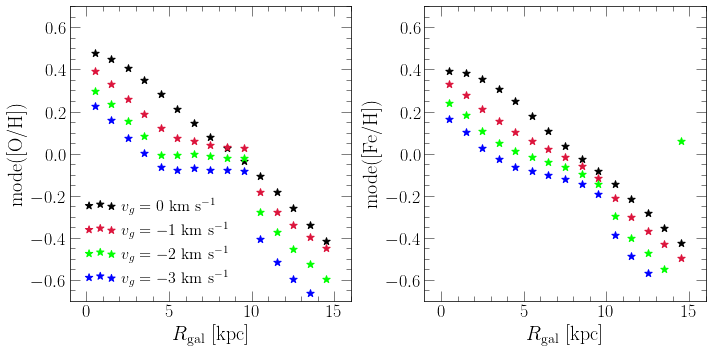

In [32]:
fig = plt.figure(figsize = (10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for ax in [ax1, ax2]:
    ax.set_xlabel(r"$R_\text{gal}$ [kpc]")
    ax.set_xlim([-1, 16])
    ax.set_ylim([-0.7, 0.7])
ax1.set_ylabel("mode([O/H])")
ax2.set_ylabel("mode([Fe/H])")

def mode(bins, dist):
    idxmax = dist.index(max(dist))
    return (bins[idxmax] + bins[idxmax + 1]) / 2

zone_width = 0.1
radial_bins = list(range(0, 16, 1))
colors = ["black", "crimson", "lime", "blue"]
velocities = [0, -1, -2, -3]
files = []
for i in range(4): files.append("./multizone/vrad%d_stellar_gradient.out" % (i))
predictions = [np.genfromtxt(file) for file in files]

for pred_idx, pred in enumerate(predictions):
    radii = pred[:,0]
    oh_16th = pred[:, 1]
    oh_mode = pred[:, 2]
    oh_84th = pred[:, 3]
    feh_16th = pred[:, 4]
    feh_mode = pred[:, 5]
    feh_84th = pred[:, 6]
    
    kwargs = {
        "c": named_colors()[colors[pred_idx]],
        "marker": markers()["star"],
        "s": 60,
        "label": r"$v_g = %d$ km s$^{-1}$" % (velocities[pred_idx])
    }
    ax1.scatter(radii, oh_mode, **kwargs)
    ax2.scatter(radii, feh_mode, **kwargs)
    
#     kwargs = {
#         "color": named_colors()[colors[pred_idx]],
#         "alpha": 0.05
#     }
#     ax1.fill_between(radii, oh_16th, oh_84th, **kwargs)
#     ax2.fill_between(radii, feh_16th, feh_84th, **kwargs)

#     del kwargs["marker"]
#     del kwargs["s"]
#     kwargs["label"] = None
#     kwargs["linestyle"] = ':'
#     kwargs["alpha"] = 0.3
#     ax1.plot(radii, oh_16th, **kwargs)
#     ax1.plot(radii, oh_84th, **kwargs)
#     ax2.plot(radii, feh_16th, **kwargs)
#     ax2.plot(radii, feh_84th, **kwargs)
    

# for i, out in enumerate(outputs):
#     for j in range(len(radial_bins) - 1):
#         inner_zone = int(radial_bins[j] / zone_width)
#         outer_zone = int(radial_bins[j + 1] / zone_width - 1)
#         stars = out.stars.filter(
#             "zone_final", ">=", inner_zone).filter(
#             "zone_final", "<=", outer_zone).filter(
#             "absz", "<=", 0.5).filter(
#             "mass", ">=", 1)
#         print(inner_zone, outer_zone, "N stellar pops: %d" % (len(stars["absz"])))
#         bins = [-3 + 0.01 * _ for _ in range(601)]
#         mdf, _ = np.histogram(stars["[o/h]"], bins = bins, density = True, weights = stars["mass"])
#         mode_ = mode(bins, mdf.tolist())
#         radius = (radial_bins[j] + radial_bins[j + 1]) / 2
#         kwargs = {
#             "c": named_colors()[colors[i]],
#             "marker": markers()["star"], 
#             "s": 40
#         }
#         ax1.scatter(radius, mode_, **kwargs)
#         mdf, _ = np.histogram(stars["[fe/h]"], bins = bins, density = True, weights = stars["mass"])
#         mode_ = mode(bins, mdf.tolist())
#         radius = (radial_bins[j] + radial_bins[j + 1]) / 2
#         ax2.scatter(radius, mode_, **kwargs)

kwargs = {
    "loc": mpl_loc("lower left"),
    "fontsize": 16,
    "scatterpoints": 3,
    "labelspacing": 0.4
}
leg = ax1.legend(**kwargs)

plt.tight_layout()
plt.savefig("./paperfigures/gradient_fiducial_radflows.pdf")
plt.show()